In [12]:
import pandas as pd

df = pd.read_csv("data/processed/merged/merged_dataset.02.csv")

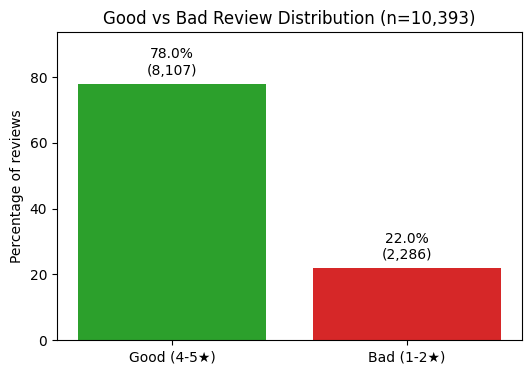

In [13]:
import matplotlib.pyplot as plt

GOOD_BAD_COUNTS = {
    'Good (4-5★)': int(df['rating'].isin([4, 5]).sum()),
    'Bad (1-2★)': int(df['rating'].isin([1, 2]).sum()),
}
counts = pd.Series(GOOD_BAD_COUNTS)
total = counts.sum()
if total == 0:
    print('No labeled reviews (ratings 1/2/4/5) available for plotting.')
else:
    percentages = (counts / total) * 100
    fig, ax = plt.subplots(figsize=(6, 4))
    colors = ['#2ca02c', '#d62728']
    bars = ax.bar(percentages.index, percentages.values, color=colors[: len(percentages)])
    ax.set_ylabel('Percentage of reviews')
    ax.set_title(f'Good vs Bad Review Distribution (n={total:,})')
    ylim_top = max(percentages.max() * 1.2, 15)
    ax.set_ylim(0, ylim_top)
    for bar, label in zip(bars, percentages.index):
        pct = percentages[label]
        count = counts[label]
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + ylim_top * 0.02,
            f"{pct:.1f}%\n({count:,})",
            ha='center',
            va='bottom',
        )
    plt.show()


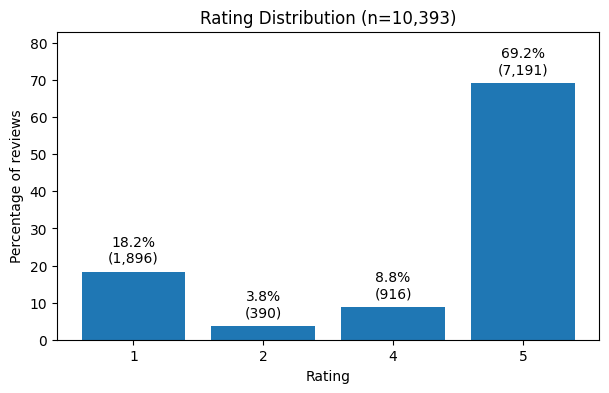

In [14]:
filtered = df[df['rating'].isin([1, 2, 4, 5])]
counts = filtered['rating'].value_counts().reindex([1, 2, 4, 5], fill_value=0)
total = counts.sum()
if total == 0:
    print('No ratings 1, 2, 4, or 5 available for plotting.')
else:
    percentages = (counts / total) * 100
    fig, ax = plt.subplots(figsize=(7, 4))
    bars = ax.bar(counts.index.astype(str), percentages.values, color='#1f77b4')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Percentage of reviews')
    ax.set_title(f'Rating Distribution (n={total:,})')
    ylim_top = max(percentages.max() * 1.2, 15)
    ax.set_ylim(0, ylim_top)
    for bar, rating in zip(bars, counts.index):
        pct = percentages.loc[rating]
        count = counts.loc[rating]
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + ylim_top * 0.02,
            f"{pct:.1f}%\n({int(count):,})",
            ha='center',
            va='bottom',
        )
    plt.show()


As seen above, the crafted dataset has a very high class imbalance, with an 80%/20% distribution. To evaluate our sentiment classifier, we will use metrics which address this problem: 
- Macro-F1 - insensitive to class imbalances. This metric gives equal weight to the negative and positive classes. Computing the arithmetic mean of the F1 scores calculated independently for each class
- F1 Scores computed for each class - Shows on which class the model performs poorly.
- PR-AUC focuses on true positives, false positives and false negatives, ignoring true negatives. This captures how well the model can retrieve bad reviews accross different thresholds, helping us understand the trade-off between precision and recall for the minority class. 

These metrics will be computed for our majority class baseline. This dummy/baseline model, will then be compared with our trained model.

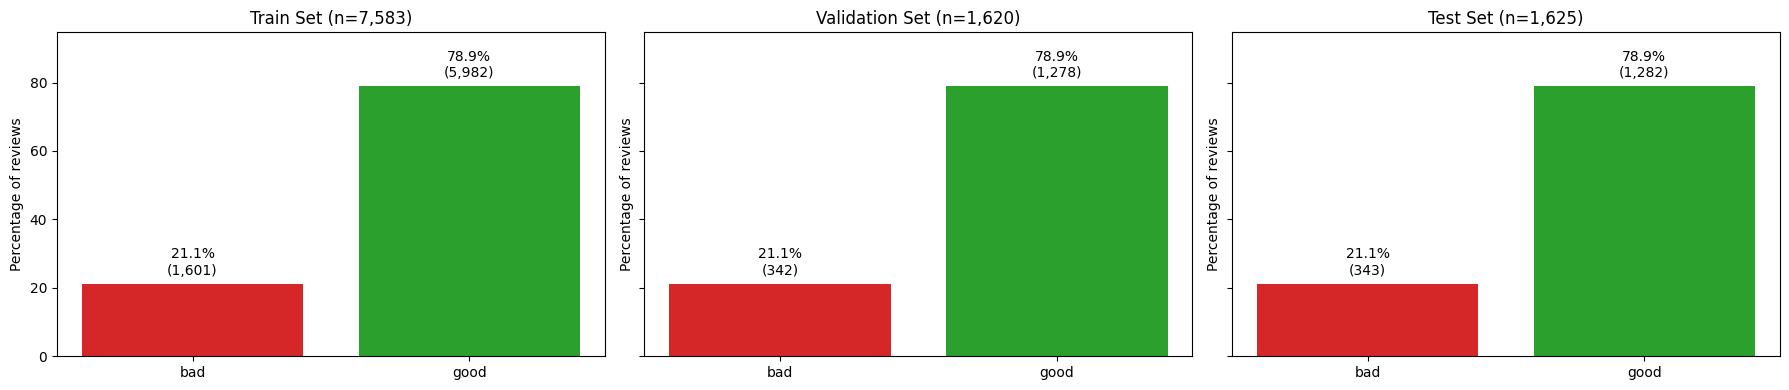

In [25]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Add the binary class for good-bad reviews
df["sentiment"] = df["rating"].apply(lambda s: "bad" if s <= 2 else "good")

train, test = train_test_split(df, test_size=0.15, stratify=df["sentiment"])
train, val = train_test_split(train, test_size=0.176, stratify=train["sentiment"])


def plot_class_distribution(ax, data, column, title, palette=None):
    palette = palette or ["#d62728", "#2ca02c"]
    counts = data[column].value_counts().sort_index()
    total = counts.sum()
    if total == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_axis_off()
        return
    percentages = (counts / total) * 100
    bars = ax.bar(counts.index.astype(str), percentages.values, color=palette[: len(counts)])
    ax.set_ylabel("Percentage of reviews")
    ax.set_title(f"{title} (n={total:,})")
    ylim_top = max(percentages.max() * 1.2, 15)
    ax.set_ylim(0, ylim_top)
    for bar, pct, count in zip(bars, percentages.values, counts.values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + ylim_top * 0.02,
            f"{pct:.1f}%\n({int(count):,})",
            ha="center",
            va="bottom",
        )


fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
plot_class_distribution(axes[0], train, "sentiment", "Train Set")
plot_class_distribution(axes[1], val, "sentiment", "Validation Set")
plot_class_distribution(axes[2], test, "sentiment", "Test Set")
plt.tight_layout()
plt.show()
